In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pykrige.ok3d import OrdinaryKriging3D
import ipywidgets
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from pykrige.rk import Krige
from pykrige.uk3d import UniversalKriging3D
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
# Leemos los datos

df = pd.read_table('datos.txt', sep = ' ')
df.columns = [column.replace(" ", "_") for column in df.columns]
df.head(10)

,id,x,y,z,tonn,blockvalue,destination,CU%,process_profit
0,0,11,0,18,16380,-12285.0,2,0.0,0.0
1,1,12,0,18,16380,-12285.0,2,0.0,0.0
2,2,13,0,18,16380,-12285.0,2,0.0,0.0
3,3,13,1,18,16380,-12285.0,2,0.0,0.0
4,4,14,0,18,16380,-12285.0,2,0.0,0.0
5,5,14,1,18,16380,-12285.0,2,0.0,0.0
6,6,15,1,18,16380,-12285.0,2,0.0,0.0
7,7,16,1,18,16380,-12285.0,2,0.0,0.0
8,8,7,0,17,16380,-12285.0,2,0.0,0.0
9,9,8,0,17,12000,-9000.0,2,0.0,0.0


In [4]:
# Vemos si hay valores Nan

check_for_nan = df.isnull().values.any()
print (check_for_nan)

False


In [5]:
# Indicadores generales del data frame

df_tem = df.drop(columns=['id','blockvalue','destination','process_profit'])
df_tem.describe()

,x,y,z,tonn,CU%
count,14153.000000,14153.000000,14153.000000,14153.000000,14153.000000
mean,41.677383,19.022893,10.666714,15736.597188,0.353761
std,18.497473,7.440534,3.406372,1022.696868,0.435775
min,0.000000,0.000000,0.000000,12000.000000,0.000000
25%,27.000000,14.000000,9.000000,15360.000000,0.000000
50%,44.000000,19.000000,11.000000,16140.000000,0.000000
75%,57.000000,24.000000,13.000000,16260.000000,0.791000
max,77.000000,41.000000,18.000000,16380.000000,1.830000


In [6]:
# número total de observaciones

df.shape

(14153, 9)

# Tubos Aleatorios

Aquí de manera aleatoria se selecciona un par (x,y) del dataset y sus correspondientes valores z y CU%.

In [7]:
i=0
combined_df = pd.DataFrame()
combined_dfm = pd.DataFrame()

while (combined_df.shape)[0]<1600:
    df_tem  = df.sample(n=1)
    df_tem = df_tem.drop(columns=['id', 'z','blockvalue','destination','process_profit','tonn','CU%'])
    df_tem_two = np.array(df_tem)
    A = df_tem_two[0][0]
    B = df_tem_two[0][1]
    df_tem_three = df.query('x == @A and y == @B', inplace=False)
    if (combined_df.shape)[0]<150:
        combined_dfm = pd.concat([combined_dfm, df_tem_three], ignore_index=True)
        combined_dfm = combined_dfm.drop_duplicates()
    combined_df = pd.concat([combined_df, df_tem_three], ignore_index=True)
    combined_df = combined_df.drop_duplicates()
    i=i+1

In [8]:
combined_df.head(10)

,id,x,y,z,tonn,blockvalue,destination,CU%,process_profit
0,1828,14,18,14,16380,-12285.0000,2,0.000,0.0000
1,3342,14,18,13,12000,-9000.0000,2,0.000,0.0000
2,5024,14,18,12,16140,121404.5450,1,0.909,133509.5450
3,6713,14,18,11,16140,124265.9441,1,0.930,136370.9441
4,8226,14,18,10,16260,342899.6380,1,1.729,355094.6380
5,9576,14,18,9,16260,241064.4830,1,1.338,253259.4830
6,10745,14,18,8,16260,146729.1618,1,0.951,158924.1618
7,11735,14,18,7,16260,124226.9941,1,0.836,136421.9941
8,12419,14,18,6,16260,102452.6961,1,0.729,114647.6961
9,1245,43,17,15,15360,-11520.0000,2,0.000,0.0000


In [9]:
combined_df.shape

(1605, 9)

In [10]:
combined_dfm.head(10)

,id,x,y,z,tonn,blockvalue,destination,CU%,process_profit
0,1828,14,18,14,16380,-12285.0000,2,0.000,0.0000
1,3342,14,18,13,12000,-9000.0000,2,0.000,0.0000
2,5024,14,18,12,16140,121404.5450,1,0.909,133509.5450
3,6713,14,18,11,16140,124265.9441,1,0.930,136370.9441
4,8226,14,18,10,16260,342899.6380,1,1.729,355094.6380
5,9576,14,18,9,16260,241064.4830,1,1.338,253259.4830
6,10745,14,18,8,16260,146729.1618,1,0.951,158924.1618
7,11735,14,18,7,16260,124226.9941,1,0.836,136421.9941
8,12419,14,18,6,16260,102452.6961,1,0.729,114647.6961
9,1245,43,17,15,15360,-11520.0000,2,0.000,0.0000


In [11]:
combined_dfm.shape

(153, 9)

In [12]:
XX = combined_df.drop(columns=['id', 'y', 'z', 'blockvalue','destination','process_profit','tonn','CU%'])
YY = combined_df.drop(columns=['id', 'x', 'z', 'blockvalue','destination','process_profit','tonn','CU%'])
ZZ = combined_df.drop(columns=['id', 'x', 'y', 'blockvalue','destination','process_profit','tonn','CU%'])
CUU = combined_df.drop(columns=['id', 'x', 'y', 'z', 'blockvalue','destination','process_profit','tonn'])

In [13]:
XX = (np.array(XX).astype(float)).flatten()
YY = (np.array(YY).astype(float)).flatten()
ZZ = (np.array(ZZ).astype(float)).flatten()
CUU = (np.array(CUU).astype(float)).flatten()

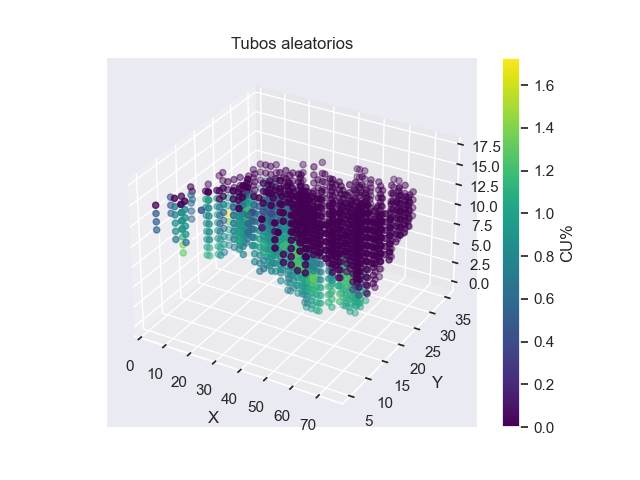

In [14]:
%matplotlib widget

# Create a new figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(XX, YY, ZZ, c=CUU, cmap='viridis')

# Add a colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('CU%')


# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('Tubos aleatorios')

# Show the plot
plt.show()

In [15]:
XV = combined_dfm.drop(columns=['id','blockvalue','destination','process_profit','tonn','CU%'])
XV.head()

,x,y,z
0,14,18,14
1,14,18,13
2,14,18,12
3,14,18,11
4,14,18,10


In [16]:
XV = np.array(XV).astype(float)

In [17]:
cu_value = np.array(combined_dfm['CU%']).astype(float)

In [18]:
# 3D Kring param opt

param_dict3d = {
    "method": ["ordinary3d", "universal3d"],
    "variogram_model": ["linear", "power", "gaussian", "spherical"],
     "nlags": [4, 6, 8, 10],
     "weight": [True, False]
}

estimator = GridSearchCV(Krige(), param_dict3d, verbose=True, return_train_score=True)

# run the gridsearch
estimator.fit(X=XV, y=cu_value)


if hasattr(estimator, "best_score_"):
    print("best_score R² = {:.3f}".format(estimator.best_score_))
    print("best_params = ", estimator.best_params_)

print("\nCV results::")
if hasattr(estimator, "cv_results_"):
    for key in [
        "mean_test_score",
        "mean_train_score",
        "param_method",
        "param_variogram_model",
    ]:
        print(" - {} : {}".format(key, estimator.cv_results_[key]))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points wil

In [19]:
x = np.array(combined_df['x']).astype(float)
y = np.array(combined_df['y']).astype(float)
z = np.array(combined_df['z']).astype(float)
cu_value = np.array(combined_df['CU%']).astype(float)

# Kriging
El subpaquete gstools.krige proporciona rutinas para la regresión del proceso gaussiano, también conocida como kriging. El kriging es un método de interpolación de datos basado en modelos de covarianza predefinidos.

El objetivo del kriging es derivar el valor de un campo en algún punto $$x_0$$, cuando hay valores observados fijos $$z\left(x_1\right) \ldots z\left(x_n\right)$$ en puntos dados $$x_i$$.

El valor resultante $$z_0$$ en $$x_0$$ se calcula como una media ponderada:
$$
z_0=\sum_{i=1}^n w_i \cdot z_i
$$

Los pesos $$W=\left(w_1, \ldots, w_n\right)$$ dependen del modelo de covarianza dado y la ubicación del punto objetivo.

Los diferentes enfoques de kriging proporcionan diferentes formas de calcular $$\boldsymbol{W}$$.

La clase Krige proporciona todo en un solo lugar y puedes activar/desactivar las características que quieras:
- **unbiased**: los pesos tienen que sumar 1. Si es verdadero, esto resulta en kriging ordinario, donde se estima la media, de lo contrario, resultará en kriging simple, donde la media tiene que ser dada.

- **drift_functions**: puedes dar un orden polinomial o una lista de funciones definidas por ti mismo que representan la deriva interna de los valores dados. Esta deriva se ajustará internamente durante la interpolación de kriging. Esto resulta en kriging Universal.

- **ext_drift**: También puedes dar una deriva externa por punto a la rutina. A diferencia de la deriva interna, que se evalúa en los puntos deseados con las funciones dadas, la deriva externa tiene que darse para cada punto de una fuente "externa". Esto resulta en kriging ExtDrift.

- **trend, mean, normalizer**: Estos se utilizan para preprocesar y postprocesar datos. Si ya tienes un modelo de tendencia ajustado que se proporciona como una función invocable, puedes dárselo a la rutina de kriging. Los normalizadores son transformaciones de potencia para ganar normalidad. mean se comporta de manera similar a trend pero se aplica en otra posición:

    - los datos de acondicionamiento se des-tendencian (restando trend)

    - los datos de acondicionamiento des-tendenciados se normalizan (para seguir una distribución normal)

    - los datos de acondicionamiento normalizados se establecen en media cero (restando mean)

Consecuentemente, cuando no se da ningún normalizador, trend y mean son la misma cosa y solo se debe usar uno. El kriging des-tendenciado es un atajo para proporcionar solo una tendencia y kriging simple con datos normales.

- **exact and cond_err**: Para incorporar el efecto nugget y/o errores de medición, se puede establecer exact en Falso y proporcionar errores de medición individuales para cada punto o establecer el nugget como un error de medición constante en todas partes.

- **pseudo_inv**: A veces, la inversión de la matriz de kriging puede ser numéricamente inestable. Esto ocurre, por ejemplo, en casos de valores de entrada redundantes. En este caso, proporcionamos un interruptor para usar la pseudo-inversa de la matriz. Entonces los valores condicionales redundantes se promediarán automáticamente.


# Kriging Ordinario

El kriging ordinario estimará una media apropiada del campo, basada en las observaciones/condiciones dadas y el modelo de covarianza utilizado.

El sistema resultante de ecuaciones para $W$ se da por:

$$
\binom{W}{\mu}=\left(\begin{array}{cccc}
c\left(x_1, x_1\right) & \cdots & c\left(x_1, x_n\right) & 1 \\
\vdots & \ddots & \vdots & \vdots \\
c\left(x_n, x_1\right) & \cdots & c\left(x_n, x_n\right) & 1 \\
1 & \cdots & 1 & 0
\end{array}\right)^{-1}\left(\begin{array}{c}
c\left(x_1, x_0\right) \\
\vdots \\
c\left(x_n, x_0\right) \\
1
\end{array}\right)
$$

Por lo tanto, $c\left(x_i, x_j\right)$ es la covarianza de las observaciones dadas y $\mu$ es un multiplicador de Lagrange para minimizar el error de kriging y estimar la media.


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 0.15128487292839687
Full Sill: 0.2640033565873201
Range: 52.19097404853205
Nugget: 0.11271848365892322 



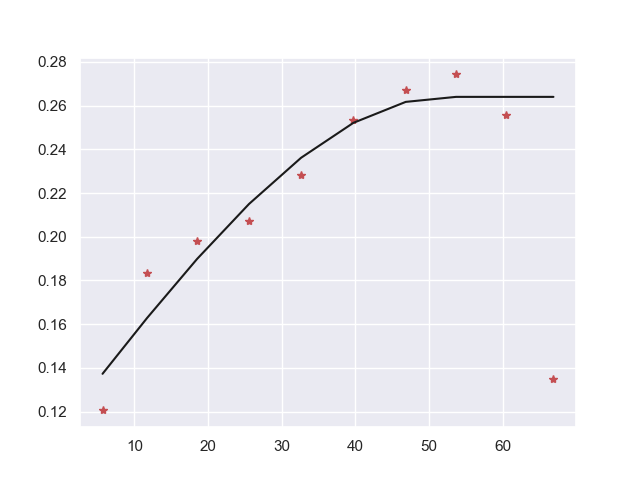

Calculating statistics on variogram model fit...
Q1 = 0.013416985665785112
Q2 = 0.41737288787269355
cR = 0.054067208314323656 



In [20]:
ok3d = OrdinaryKriging3D(x,y,z,cu_value, variogram_model='spherical', nlags=10, weight=True, enable_plotting=True, verbose=True)

In [21]:
gridx = np.linspace(0.0, max(np.array(combined_df['x']).astype(float)), 30)
gridy = np.linspace(0.0, max(np.array(combined_df['y']).astype(float)), 30)
gridz = np.linspace(0.0, max(np.array(combined_df['z']).astype(float)), 30)

# Execute 3D ordinary kriging
k3d1, ss3d = ok3d.execute("grid", gridx, gridy, gridz)

# Create a meshgrid for the scatter plot
X, Y, Z = np.meshgrid(gridx, gridy, gridz, indexing='ij')

Executing Ordinary Kriging...



In [22]:
i = 0
j = 0
k = 0
l_l = []

while i < len(gridx):
    while j < len(gridy):
        while k < len(gridz):
            tem = [X[i][j][k], Y[i][j][k], Z[i][j][k], k3d1[k][j][i]]
            l_l.append(tem)
            k = k + 1
        k = 0
        j = j + 1
    j = 0
    i = i + 1

matrix = np.array(l_l)
df_k3d1 = pd.DataFrame(matrix, columns=['Xg', 'Yg', 'Zg', 'CUk'])

# Graficos

A continuacion se muestran los graficos de la predicción de CU% mediante Kriging Ordinario para una
malla de puntos dada. El primer grafico corresponde a la malla completa y los siguientes 3 correspondes a los
conjuntos de nivel de la malla.

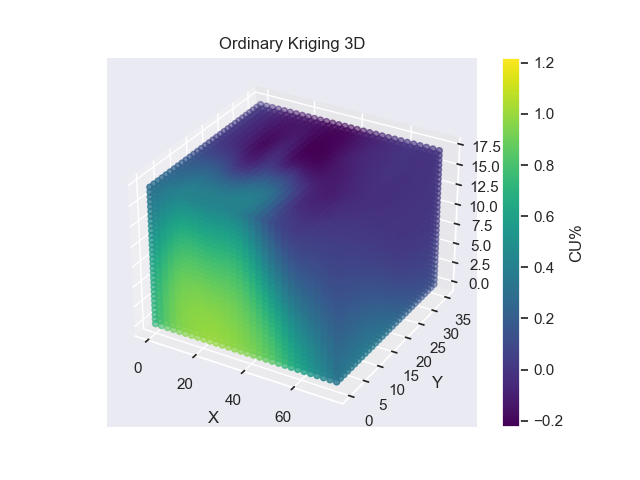

In [23]:
%matplotlib widget

# Create a new figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(matrix[:,0], matrix[:,1], matrix[:,2], c=matrix[:,3], cmap='viridis')

# Add a colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('CU%')


# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('Ordinary Kriging 3D')

# Show the plot
plt.show()

In [24]:
def plot_X_Y(z):

    df_tem = df_k3d1.query('Zg == @z', inplace=False)

    M0 = np.array(df_tem['Xg']).astype(float)
    M1 = np.array(df_tem['Yg']).astype(float)
    M2 = np.array(df_tem['Zg']).astype(float)
    M3 = np.array(df_tem['CUk']).astype(float)

    # Create a new figure
    fig = plt.figure()

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot
    scatter = ax.scatter(M0, M1, M2, c=M3, cmap='viridis')

    # Add a colorbar
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('CU%')


    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set title
    ax.set_title('Ordinary Kriging 3D X-Y Plane')

    # Show the plot
    plt.show()

In [25]:
z_values = gridz
z_slider = ipywidgets.SelectionSlider(options=z_values.tolist())
ipywidgets.interact(plot_X_Y, z=z_slider)

interactive(children=(SelectionSlider(description='z', options=(0.0, 0.5862068965517241, 1.1724137931034482, 1…

<function __main__.plot_X_Y(z)>

In [26]:
def plot_Y_Z(x):

    df_tem = df_k3d1.query('Xg == @x', inplace=False)

    M0 = np.array(df_tem['Xg']).astype(float)
    M1 = np.array(df_tem['Yg']).astype(float)
    M2 = np.array(df_tem['Zg']).astype(float)
    M3 = np.array(df_tem['CUk']).astype(float)

    # Create a new figure
    fig = plt.figure()

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot
    scatter = ax.scatter(M0, M1, M2, c=M3, cmap='viridis')

    # Add a colorbar
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('CU%')


    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set title
    ax.set_title('Ordinary Kriging 3D Y-Z Plane')

    # Show the plot
    plt.show()

In [27]:
x_values = gridx
x_slider = ipywidgets.SelectionSlider(options=x_values.tolist())
ipywidgets.interact(plot_Y_Z, x=x_slider)

interactive(children=(SelectionSlider(description='x', options=(0.0, 2.5517241379310347, 5.103448275862069, 7.…

<function __main__.plot_Y_Z(x)>

In [28]:
def plot_X_Z(y):

    df_tem = df_k3d1.query('Yg == @y', inplace=False)

    M0 = np.array(df_tem['Xg']).astype(float)
    M1 = np.array(df_tem['Yg']).astype(float)
    M2 = np.array(df_tem['Zg']).astype(float)
    M3 = np.array(df_tem['CUk']).astype(float)

    # Create a new figure
    fig = plt.figure()

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot
    scatter = ax.scatter(M0, M1, M2, c=M3, cmap='viridis')

    # Add a colorbar
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('CU%')


    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set title
    ax.set_title('Ordinary Kriging 3D Y-Z Plane')

    # Show the plot
    plt.show()

In [29]:
y_values = gridy
y_slider = ipywidgets.SelectionSlider(options=y_values.tolist())
ipywidgets.interact(plot_X_Z, y=y_slider)

interactive(children=(SelectionSlider(description='y', options=(0.0, 1.206896551724138, 2.413793103448276, 3.6…

<function __main__.plot_X_Z(y)>

# kriging universal

El kriging universal asume un modelo de tendencia polinomial general, como el modelo de tendencia lineal $$E{Z(x)}=\sum_{k=0}^p \beta_k f_k(x)$$.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'power' Variogram Model
Scale: 0.07417568410099103
Exponent: 0.32969356658104954
Nugget: 1.072313350386741e-15 



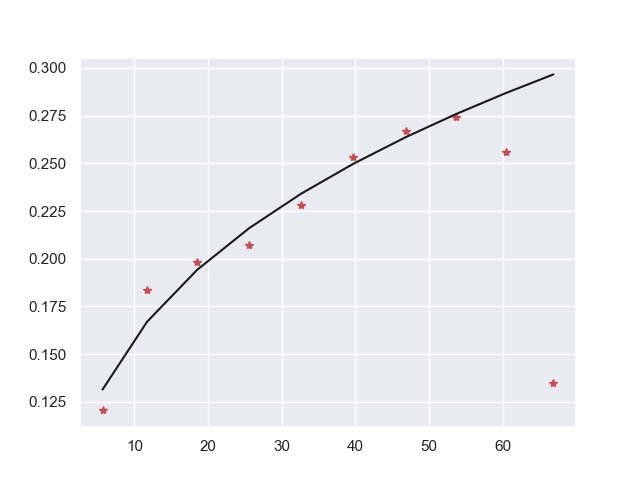

Calculating statistics on variogram model fit...
Q1 = 0.022478900540978636
Q2 = 0.4036041178047691
cR = 0.039550694138922864 

Initializing drift terms...


In [41]:
uk3d = UniversalKriging3D(x,y,z,cu_value, variogram_model='power', nlags=10, weight=True, enable_plotting=True, verbose=True)

In [42]:
gridx = np.linspace(0.0, max(np.array(combined_df['x']).astype(float)), 30)
gridy = np.linspace(0.0, max(np.array(combined_df['y']).astype(float)), 30)
gridz = np.linspace(0.0, max(np.array(combined_df['z']).astype(float)), 30)

# Execute 3D universal kriging
k3d2, ss3d2 = uk3d.execute("grid", gridx, gridy, gridz)

# Create a meshgrid for the scatter plot
X, Y, Z = np.meshgrid(gridx, gridy, gridz, indexing='ij')

Executing Universal Kriging...



In [43]:
i = 0
j = 0
k = 0
l_l = []

while i < len(gridx):
    while j < len(gridy):
        while k < len(gridz):
            tem = [X[i][j][k], Y[i][j][k], Z[i][j][k], k3d2[k][j][i]]
            l_l.append(tem)
            k = k + 1
        k = 0
        j = j + 1
    j = 0
    i = i + 1

matrix_2 = np.array(l_l)
df_k3d2 = pd.DataFrame(matrix_2, columns=['Xg', 'Yg', 'Zg', 'CUk'])

# Graficos

A continuacion se muestran los graficos de la predicción de CU% mediante Kriging Universal para una
malla de puntos dada. El primer grafico corresponde a la malla completa y los siguientes 3 correspondes a los
conjuntos de nivel de la malla.

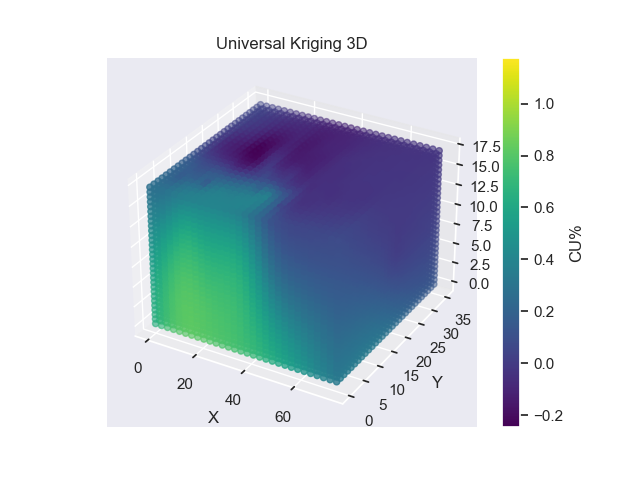

In [44]:
%matplotlib widget

# Create a new figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(matrix_2[:,0], matrix_2[:,1], matrix_2[:,2], c=matrix_2[:,3], cmap='viridis')

# Add a colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('CU%')


# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('Universal Kriging 3D')

# Show the plot
plt.show()

In [46]:
def plot_X_Y_u(z):

    df_tem = df_k3d2.query('Zg == @z', inplace=False)

    M0 = np.array(df_tem['Xg']).astype(float)
    M1 = np.array(df_tem['Yg']).astype(float)
    M2 = np.array(df_tem['Zg']).astype(float)
    M3 = np.array(df_tem['CUk']).astype(float)

    # Create a new figure
    fig = plt.figure()

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot
    scatter = ax.scatter(M0, M1, M2, c=M3, cmap='viridis')

    # Add a colorbar
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('CU%')


    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set title
    ax.set_title('Universal Kriging 3D X-Y Plane')

    # Show the plot
    plt.show()

In [47]:
z_values = gridz
z_slider = ipywidgets.SelectionSlider(options=z_values.tolist())
ipywidgets.interact(plot_X_Y_u, z=z_slider)

interactive(children=(SelectionSlider(description='z', options=(0.0, 0.5862068965517241, 1.1724137931034482, 1…

<function __main__.plot_X_Y_u(z)>

In [51]:
def plot_Y_Z_u(x):

    df_tem = df_k3d2.query('Xg == @x', inplace=False)

    M0 = np.array(df_tem['Xg']).astype(float)
    M1 = np.array(df_tem['Yg']).astype(float)
    M2 = np.array(df_tem['Zg']).astype(float)
    M3 = np.array(df_tem['CUk']).astype(float)

    # Create a new figure
    fig = plt.figure()

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot
    scatter = ax.scatter(M0, M1, M2, c=M3, cmap='viridis')

    # Add a colorbar
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('CU%')


    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set title
    ax.set_title('Universal Kriging 3D X-Y Plane')

    # Show the plot
    plt.show()

In [52]:
x_values = gridx
x_slider = ipywidgets.SelectionSlider(options=x_values.tolist())
ipywidgets.interact(plot_Y_Z_u, x=x_slider)

interactive(children=(SelectionSlider(description='x', options=(0.0, 2.5517241379310347, 5.103448275862069, 7.…

<function __main__.plot_Y_Z_u(x)>

In [55]:
def plot_X_Z_u(y):

    df_tem = df_k3d2.query('Yg == @y', inplace=False)

    M0 = np.array(df_tem['Xg']).astype(float)
    M1 = np.array(df_tem['Yg']).astype(float)
    M2 = np.array(df_tem['Zg']).astype(float)
    M3 = np.array(df_tem['CUk']).astype(float)

    # Create a new figure
    fig = plt.figure()

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot
    scatter = ax.scatter(M0, M1, M2, c=M3, cmap='viridis')

    # Add a colorbar
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('CU%')


    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set title
    ax.set_title('Universal Kriging 3D X-Y Plane')

    # Show the plot
    plt.show()

In [56]:
y_values = gridy
y_slider = ipywidgets.SelectionSlider(options=y_values.tolist())
ipywidgets.interact(plot_X_Z_u, y=y_slider)

interactive(children=(SelectionSlider(description='y', options=(0.0, 1.206896551724138, 2.413793103448276, 3.6…

<function __main__.plot_X_Z_u(y)>